In [1]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

df = pd.read_csv('./data/btc-usd-max.csv',index_col=0,parse_dates=True )
df = df.resample('D').first()
df['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])
df2 = pd.read_csv('./data/eth-usd-max.csv',index_col=0,parse_dates=True )
df2 = df2.resample('D').first()
df2['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])

In [2]:
df['price'].iplot(logy=True)

In [3]:
## perform a dickey-fuller test for seasonality on BTC
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [4]:
adf_test(df2['price'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.715635
p-value                    0.423075
# lags used               28.000000
# observations          2574.000000
critical value (1%)       -3.432893
critical value (5%)       -2.862664
critical value (10%)      -2.567368
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


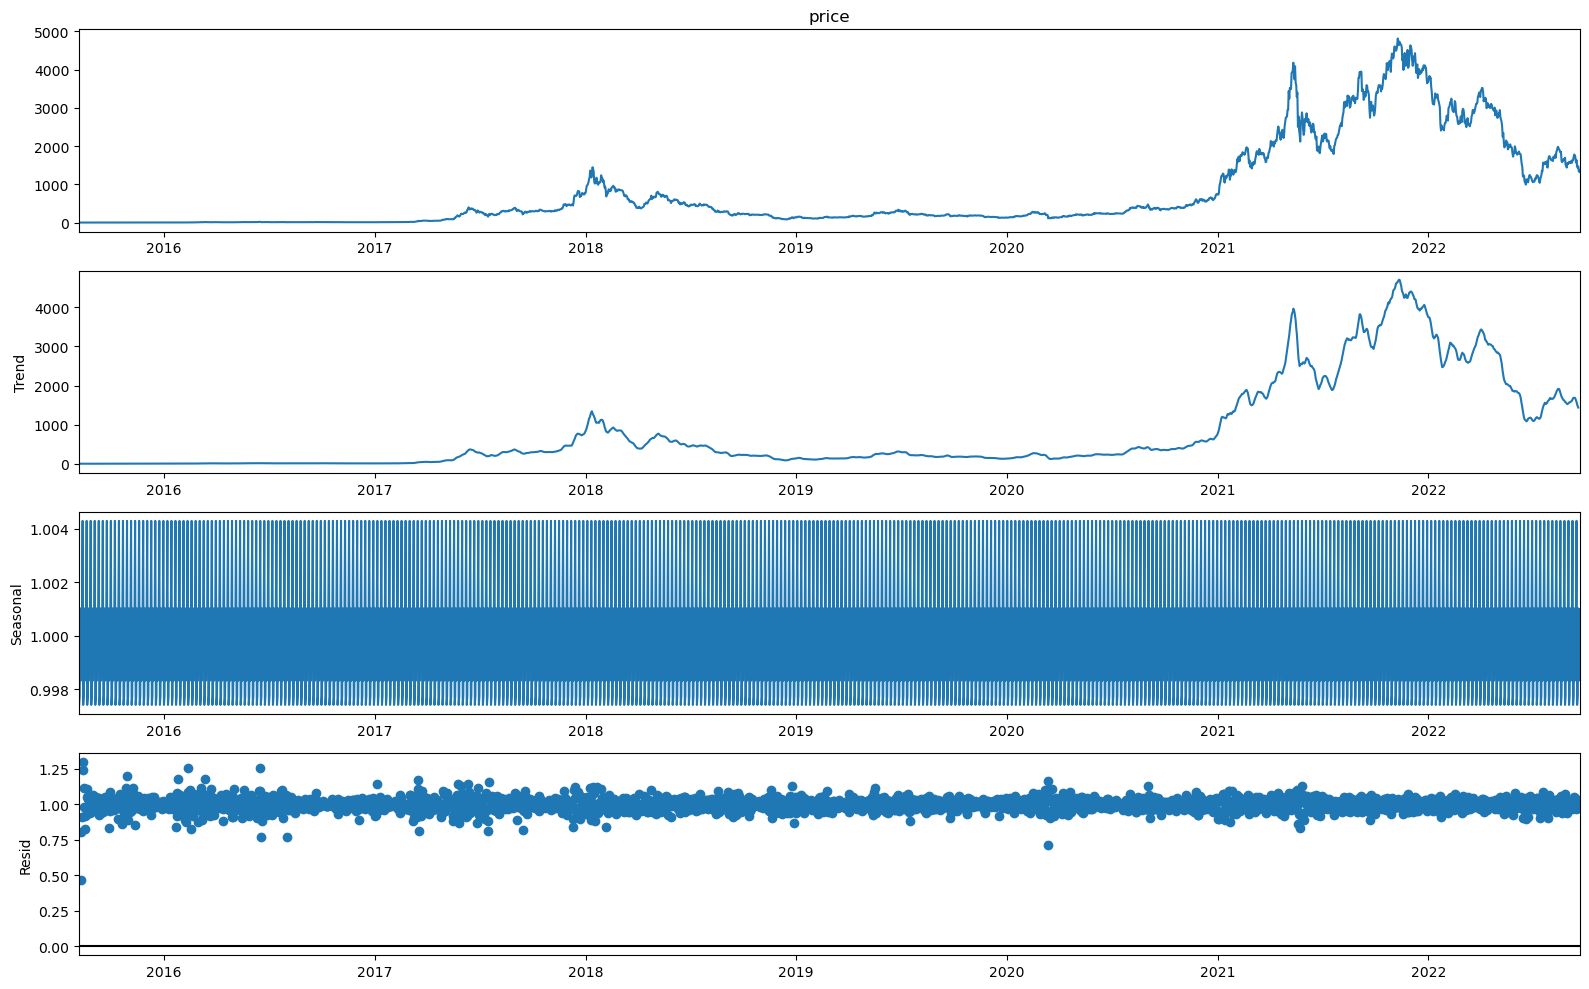

In [5]:
# perform an ETS decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['price'], model='multiplicative')  # model='mul' also works
from pylab import rcParams
rcParams['figure.figsize']= 16,10
result.plot();

In [6]:
# use auto arima to find possible p, d, q values
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# run auto_arima to evaluate p,d and q with defauls parameters
auto_arima(df2['price'], seasonal=False)

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
# we can derive the above 1,1,1 values manually
# first we see if I so 1 differentiation is enough for the data to be stationary
# as seen above currnet p for dickey fuller is 0.423075 which shows trend and seasonality
# the result we get is a p value close to zero so with 1 differentiation the data become stationary therefore prooving the 
# d =1 from the auto arima above!
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['price'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic     -8.561135e+00
p-value                 8.689160e-14
# lags used             2.800000e+01
# observations          2.573000e+03
critical value (1%)    -3.432894e+00
critical value (5%)    -2.862664e+00
critical value (10%)   -2.567368e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


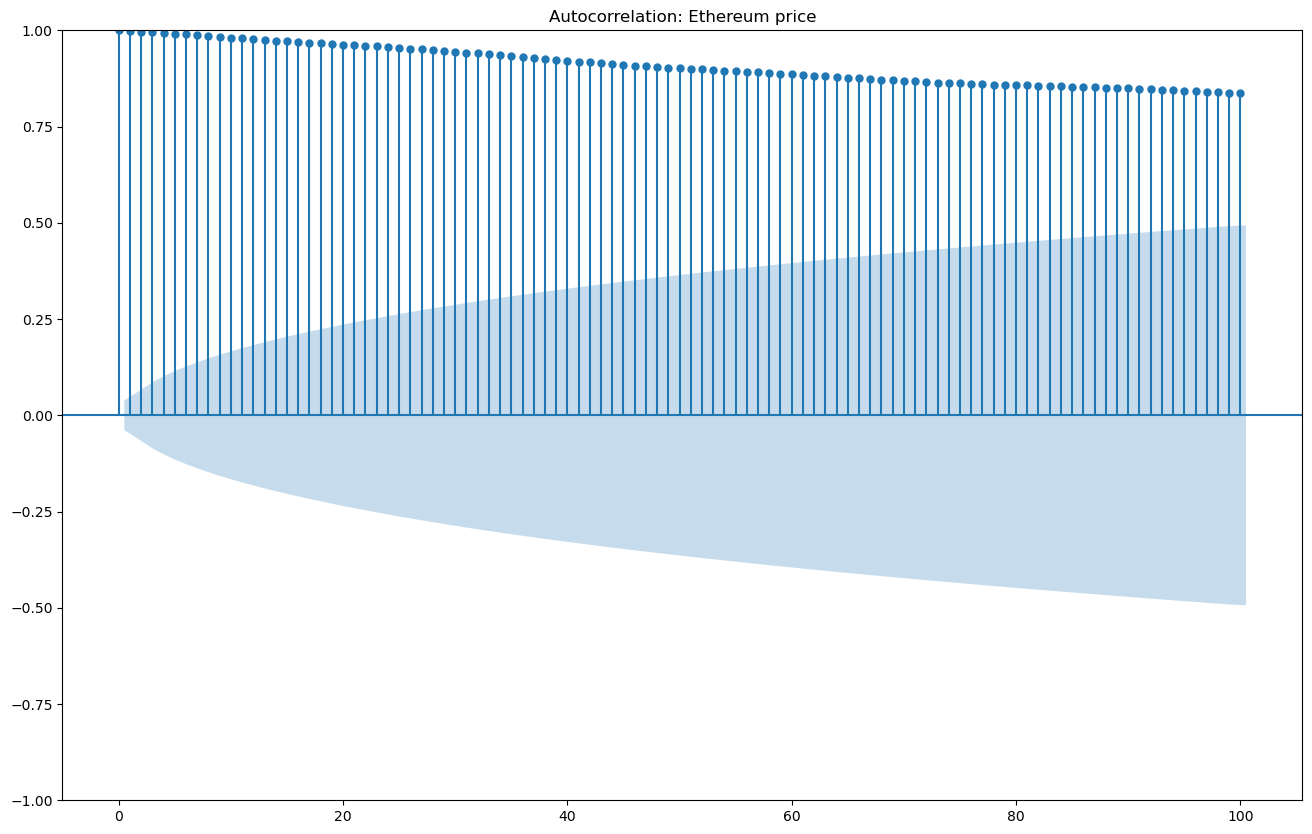

In [9]:
# now in order to see the p and d values we will plot the acf and pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
title = 'Autocorrelation: Ethereum price'
lags = 100
plot_acf(df2['price'],title=title,lags=lags);

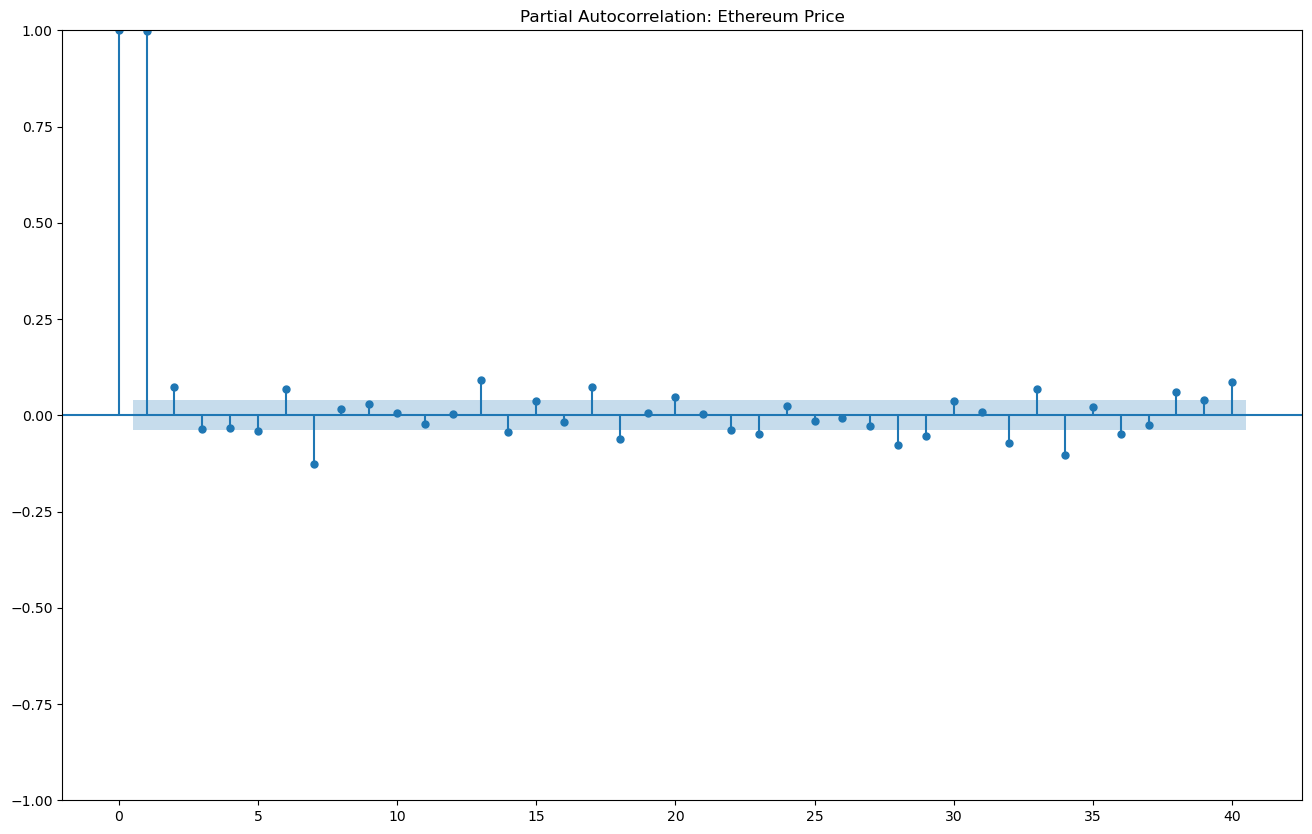

In [10]:
title = 'Partial Autocorrelation: Ethereum Price'
lags = 40
plot_pacf(df2['price'],title=title,lags=lags);

In [11]:
# from the above and looking at vaious interpretation maulas online, The AR term can be determined by the PACF
# chart at the point where there is a stip drop so we start at 0 lag , then 1 and so on. the lag the valu falls a lot
# is conisdered the p value for AR. then we check both the ACF and the PACF. if the ACF is not stip then depending on 
# the AR found before we can either day q = 0 or 1 so we try bouth and evaluate the results. 
# https://people.duke.edu/~rnau/411arim3.htm

In [12]:
# now we will try more advanced auto arima evaluation
stepwise_fit = auto_arima(df2['price'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=10,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[10] intercept   : AIC=29218.034, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=29216.358, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=29207.308, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=29208.047, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=29214.511, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[10] intercept   : AIC=29206.849, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[10] intercept   : AIC=29207.275, Time=0.99 sec
 ARIMA(1,1,0)(1,0,1)[10] intercept   : AIC=29208.836, Time=1.62 sec
 ARIMA(2,1,0)(0,0,0)[10] intercept   : AIC=29206.356, Time=0.23 sec
 ARIMA(2,1,0)(1,0,0)[10] intercept   : AIC=29206.460, Time=0.64 sec
 ARIMA(2,1,0)(0,0,1)[10] intercept   : AIC=29206.424, Time=0.63 sec
 ARIMA(2,1,0)(1,0,1)[10] intercept   : AIC=29208.031, Time=1.59 sec
 ARIMA(3,1,0)(0,0,0)[10] intercept   : AIC=29207.335, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[10] intercept   : AIC=29206.273, Time=1.62 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2603
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -14596.505
Date:                Thu, 06 Oct 2022   AIC                          29199.011
Time:                        15:12:15   BIC                          29216.603
Sample:                    08-07-2015   HQIC                         29205.385
                         - 09-21-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8044      0.037    -21.495      0.000      -0.878      -0.731
ma.L1          0.7528      0.043     17.505      0.000       0.669       0.837
sigma2      4373.9437     36.647    119.352      0.000    4302.116    4445.771
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):             59963.05
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):             101.79   Skew:                            -1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
len(df2)

2603

In [15]:
# Set one month for testing
train = df2.iloc[:-60]
test = df2.iloc[-60:]

In [32]:
# create an ARIMA Model
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
model = ARIMA(train['price'],order=(5,1,1), seasonal_order=(0,0,0,1450))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2543
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -14236.590
Date:                Thu, 06 Oct 2022   AIC                          28487.180
Time:                        15:26:41   BIC                          28528.065
Sample:                    08-07-2015   HQIC                         28502.011
                         - 07-23-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5876      0.054    -10.909      0.000      -0.693      -0.482
ar.L2         -0.0027      0.010     -0.259      0.796      -0.023       0.018
ar.L3          0.0405      0.010      4.117      0.000       0.021       0.060
ar.L4          0.0473      0.010      4.818      0.000       0.028       0.067
ar.L5         -0.0651      0.011     -6.172      0.000      -0.086      -0.044
ma.L1          0.5318      0.055      9.617      0.000       0.423       0.640
sigma2      4286.3339     38.274    111.991      0.000    4211.318    4361.350
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             58341.79
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             157.56   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# Obtain predicted values
# CAUTION ON typ='levels'! the default is linear but in an arima model if we select linear it will predict
# based the differnced - so the stationary data and not the initial data which is what we want!!!
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(5,1,5) Predictions')

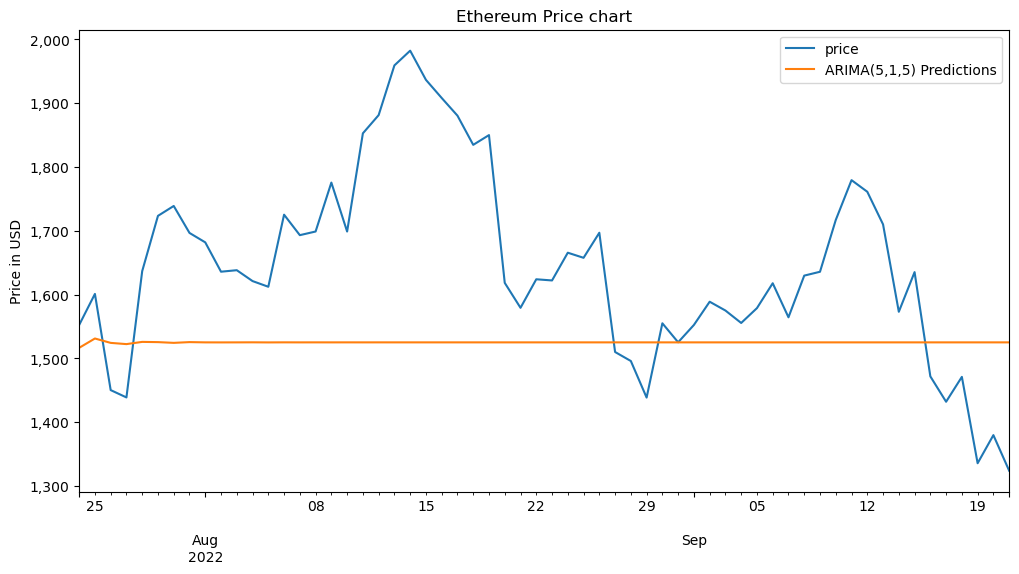

In [34]:
# Plot predictions against known values
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Ethereum Price chart'
ylabel='Price in USD'
xlabel='' # we don't really need a label here

ax = test['price'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [35]:
# evaluating the model
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['price'], predictions)
print(f'ARIMA(5,1,5) MSE Error: {error:11.10}')

ARIMA(5,1,5) MSE Error: 35789.45355


In [36]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['price'], predictions)
print(f'ARIMA(5,1,5) RMSE Error: {error:11.10}')

ARIMA(5,1,5) RMSE Error: 189.1810074


In [ ]:
# Retrain the model on the full data, and forecast the future
model = ARIMA(df2['price'],order=(1,1,1), seasonal_order=(1,1,1,1350))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+160,typ='levels').rename('ARIMA(5,1,5) Forecast')

In [ ]:
# Plot predictions against known values
title = 'Ethereum Price chart'
ylabel='Price in USD'
xlabel='' # we don't really need a label here

ax = df2['price'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [ ]:
# same plot as above but with plotly
result = df2.join(fcast, how='outer')
result[['price','ARIMA(5,1,5) Forecast']].iplot()